# MovieLens 100K: Sistem preporuka zasnovan na uzajamnom filtriranju koristeći matricu kovarijansi

Sistem preporuka je sistem koji preporučuje proizvode korisniku za koje smatra da su mu od značaja. Ovi sistemi su široko rasprostranjeni i korišćeni u različitim sferama života. Postoji više različitih vrsta takvih sistema, ovde će biti korišćen sistem zasnovan na **uzajamnom filtriranju**. Osnovna ideja uzajamnog filtriranja je da ako su korisnici imali slična interesovanja u prošlosti imaće slična interesovanja i u budućnosti, tj. da prethodno ponašanje korisnika ima ogroman uticaj na njegovo buduće ponašanje. 

Kako se ocenjuje sličnost među korisnicima? Konstruiše se matrica sličnosti, gde se sličnost može izračunati korišćenjem različitih metrika. Među korišćenim metrikama najpopularnije su kosinusna funkcija sličnosti, Pirsonov koeficijent korelacije, Žakardov indeks, razlika srednjih kvadrata, kombinacija razlike srednjih kvadrata i Žakardovog indeksa, itd. Međutim, ovakav pristup uzajamnom filtriranju može imati nekoliko problema:

**1) Kvalitet sistema preporuka zasnovanom na uzajamnom filtriranju može umnogome zavisiti od retkosti podataka.**

**2) Sistem se teško prilagođava situaciji kada se interesovanja korisnika menjaju tokom vremena.**

**3) Sistem preporučuje slične proizvode korisniku ignorišiću korisnikovu potrebu za raznolikošću.**

Zbog navedenih problema preporučen je novi pristup uzajamnom filtriranju koji se ne zasniva na matrici sličnosti među korisnicima, nego na matrici kovarijansi. Ovaj rad je zasnovan na naučnom radu koji se može pronaći na sledećoj adresi: https://www.hindawi.com/journals/mpe/2018/9740402/.

U njemu je predložen algoritam CFCM (Collaborative Filtering Covariance Matrix) kojim se rešavaju prethodno navedeni problemi i poboljšava se kvalitet preporuka. Naš zadatak je da implementiramo navedeni algoritam i da evaluiramo njegove performanse.

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

Koristićemo dostupan skup podataka pod imenom MovieLens u veličini od 100 000. Skup podataka se može naći na: https://grouplens.org/datasets/movielens/100k/.

U naučnom radu na kome se zasniva ovaj rad korišćen je skup podataka MovieLens 1M, koji se sastoji od jednog miliona podataka. Mi smo istraživanje odradile na ovom skupu od 100 000 zbog hardverskih ograničenja, ali i zbog već dostupnih trening i test podataka.

In [2]:
header = ['user', 'item', 'rating', 'timestamp']

Učitavamo ceo skup podataka.

In [3]:
data = pd.read_csv('ml-100k/u.data', sep = '\\t', names = header, engine = 'python')

In [4]:
data.head()

,user,item,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype
---  ------     --------------   -----
 0   user       100000 non-null  int64
 1   item       100000 non-null  int64
 2   rating     100000 non-null  int64
 3   timestamp  100000 non-null  int64
dtypes: int64(4)
memory usage: 3.1 MB


Proveravamo koliko različitih korisnika i filmova imamo.

In [6]:
number_of_users = data['user'].unique().shape[0]
number_of_users

943

In [7]:
number_of_items = data['item'].unique().shape[0]
number_of_items

1682

Formiramo USER-ITEM matricu podataka. Redovi predstavljaju korisnike, a kolone filmove, dok polja matrice odgovaraju ocenama koje je odgovarajući korisnik dao odgovarajućem filmu.

In [8]:
ui_matrix = pd.pivot_table(data, index = 'user', columns = 'item', values = 'rating')

In [9]:
ui_matrix

item,1,2,3,4,5,6,7,8,9,10,...,1673,1674,1675,1676,1677,1678,1679,1680,1681,1682
user,,,,,,,,,,,,,,,,,,,,,
1,5.0,3.0,4.0,3.0,3.0,5.0,4.0,1.0,5.0,3.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,4.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
939,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
940,NaN,NaN,NaN,2.0,NaN,NaN,4.0,5.0,3.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
941,5.0,NaN,NaN,NaN,NaN,NaN,4.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [10]:
ui_matrix.describe()

item,1,2,3,4,5,6,7,8,9,10,...,1673,1674,1675,1676,1677,1678,1679,1680,1681,1682
count,452.000000,131.000000,90.000000,209.000000,86.000000,26.000000,392.000000,219.000000,299.000000,89.000000,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
mean,3.878319,3.206107,3.033333,3.550239,3.302326,3.576923,3.798469,3.995434,3.896321,3.831461,...,3.0,4.0,3.0,2.0,3.0,1.0,3.0,2.0,3.0,3.0
std,0.927897,0.966497,1.212760,0.965069,0.946446,1.301478,0.982037,1.002281,1.042368,1.013948,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,3.0,4.0,3.0,2.0,3.0,1.0,3.0,2.0,3.0,3.0
25%,3.000000,3.000000,2.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,...,3.0,4.0,3.0,2.0,3.0,1.0,3.0,2.0,3.0,3.0
50%,4.000000,3.000000,3.000000,4.000000,3.000000,4.000000,4.000000,4.000000,4.000000,4.000000,...,3.0,4.0,3.0,2.0,3.0,1.0,3.0,2.0,3.0,3.0
75%,5.000000,4.000000,4.000000,4.000000,4.000000,5.000000,5.000000,5.000000,5.000000,5.000000,...,3.0,4.0,3.0,2.0,3.0,1.0,3.0,2.0,3.0,3.0
max,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,...,3.0,4.0,3.0,2.0,3.0,1.0,3.0,2.0,3.0,3.0


Možemo videti da je USER-ITEM matrica veoma retka što potpada pod jedan od navedenih problema.

Učitavamo dostupne trening podatke.

In [11]:
train_data = pd.read_csv('ml-100k/u2.base', sep = '\\t', names = header, engine = 'python')

In [12]:
train_data.head()

,user,item,rating,timestamp
0,1,3,4,878542960
1,1,4,3,876893119
2,1,5,3,889751712
3,1,6,5,887431973
4,1,7,4,875071561


In [13]:
train_data.shape

(80000, 4)

Učitavamo dostupne test podatke koji odgovaraju učitanim trening podacima.

In [14]:
test_data = pd.read_csv('ml-100k/u2.test', sep = '\\t', names = header, engine = 'python')

In [15]:
test_data.head()

,user,item,rating,timestamp
0,1,1,5,874965758
1,1,2,3,876893171
2,1,8,1,875072484
3,1,9,5,878543541
4,1,21,1,878542772


### Vizualiazacija podataka

In [16]:
genres = pd.read_csv('ml-100k/u.genre', sep = '|', names=['genre', 'id'], engine = 'python')

In [17]:
movies_header = ['item', 'title', 'date1', 'date2', 'url'] + [g for g in genres['genre']]

In [18]:
movies_header

['item',
 'title',
 'date1',
 'date2',
 'url',
 'unknown',
 'Action',
 'Adventure',
 'Animation',
 "Children's",
 'Comedy',
 'Crime',
 'Documentary',
 'Drama',
 'Fantasy',
 'Film-Noir',
 'Horror',
 'Musical',
 'Mystery',
 'Romance',
 'Sci-Fi',
 'Thriller',
 'War',
 'Western']

In [19]:
movies = pd.read_csv('ml-100k/u.item', sep = '|', names = movies_header, engine = 'python')

In [20]:
movies.head()

,item,title,date1,date2,url,unknown,Action,Adventure,Animation,Children's,...,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
1,2,GoldenEye (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(...,0,1,1,0,0,...,0,0,0,0,0,0,0,1,0,0
2,3,Four Rooms (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Four%20Rooms%...,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,4,Get Shorty (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%...,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,5,Copycat (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995),0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [21]:
del movies['date1']
del movies['date2']
del movies['url']
movies.head()

,item,title,unknown,Action,Adventure,Animation,Children's,Comedy,Crime,Documentary,...,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,Toy Story (1995),0,0,0,1,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2,GoldenEye (1995),0,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2,3,Four Rooms (1995),0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,4,Get Shorty (1995),0,1,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
4,5,Copycat (1995),0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,1,0,0


In [22]:
train_data_movies = pd.merge(train_data, movies, on = 'item')

In [23]:
train_data_movies.head()

,user,item,rating,timestamp,title,unknown,Action,Adventure,Animation,Children's,...,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,3,4,878542960,Four Rooms (1995),0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1,49,3,3,888068877,Four Rooms (1995),0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2,62,3,3,879372325,Four Rooms (1995),0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,63,3,2,875748068,Four Rooms (1995),0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
4,81,3,4,876592546,Four Rooms (1995),0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [24]:
train_data_movies.groupby('title')['rating'].mean().sort_values(ascending=False).head(10)

title
Prefontaine (1997)                            5.0
They Made Me a Criminal (1939)                5.0
Santa with Muscles (1996)                     5.0
Marlene Dietrich: Shadow and Light (1996)     5.0
Saint of Fort Washington, The (1993)          5.0
Someone Else's America (1995)                 5.0
Star Kid (1997)                               5.0
Visitors, The (Visiteurs, Les) (1993)         5.0
Golden Earrings (1947)                        5.0
Aiqing wansui (1994)                          5.0
Name: rating, dtype: float64

In [25]:
train_data_movies.groupby('title')['rating'].count().sort_values(ascending=False).head(10)

title
Star Wars (1977)                 461
Fargo (1996)                     414
Contact (1997)                   409
Return of the Jedi (1983)        406
Liar Liar (1997)                 402
English Patient, The (1996)      397
Scream (1996)                    360
Toy Story (1995)                 358
Independence Day (ID4) (1996)    351
Air Force One (1997)             345
Name: rating, dtype: int64

In [26]:
ratings = pd.DataFrame(train_data_movies.groupby('title')['rating'].mean())
ratings['count'] = pd.DataFrame(train_data_movies.groupby('title')['rating'].count())
ratings = pd.merge(ratings, movies, on='title')
ratings.sort_values(by='count', ascending=False).head(10)

,title,rating,count,item,unknown,Action,Adventure,Animation,Children's,Comedy,...,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
1386,Star Wars (1977),4.364425,461,50,0,1,1,0,0,0,...,0,0,0,0,0,1,1,0,1,0
494,Fargo (1996),4.166667,414,100,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
330,Contact (1997),3.767726,409,258,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
1221,Return of the Jedi (1983),3.985222,406,181,0,1,1,0,0,0,...,0,0,0,0,0,1,1,0,1,0
853,Liar Liar (1997),3.196517,402,294,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
456,"English Patient, The (1996)",3.672544,397,286,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,1,0
1271,Scream (1996),3.372222,360,288,0,0,0,0,0,0,...,0,0,1,0,0,0,0,1,0,0
1509,Toy Story (1995),3.888268,358,1,0,0,0,1,1,1,...,0,0,0,0,0,0,0,0,0,0
738,Independence Day (ID4) (1996),3.441595,351,121,0,1,0,0,0,0,...,0,0,0,0,0,0,1,0,1,0
32,Air Force One (1997),3.582609,345,300,0,1,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


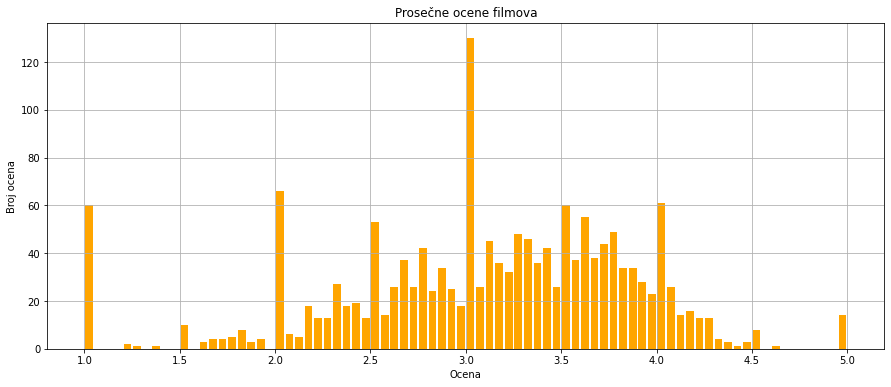

In [27]:
plt.figure(figsize=(15, 6))
ratings['rating'].hist(bins=80, rwidth=0.8, color='orange')
plt.xlabel('Ocena')
plt.ylabel('Broj ocena')
plt.title('Prosečne ocene filmova')
plt.show()

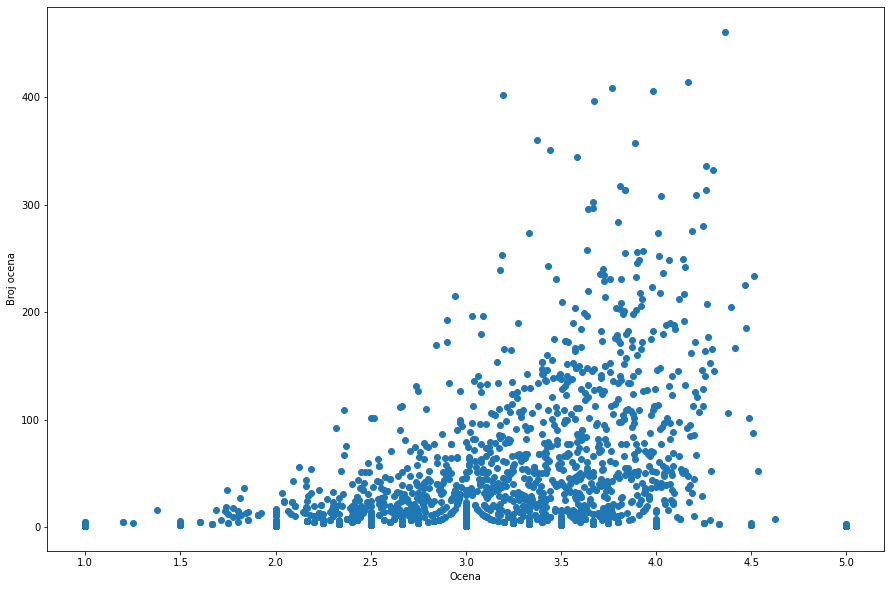

In [28]:
plt.figure(figsize=(15, 10))
plt.scatter(x = ratings['rating'], y = ratings['count'])
plt.xlabel('Ocena')
plt.ylabel('Broj ocena')
plt.show()

In [29]:
number_of_ratings_for_genre = {}
for x in genres['genre']:
    number_of_ratings_for_genre[x] = len(np.where(np.array(train_data_movies[x]) == 1)[0])

In [30]:
number_of_ratings_for_genre

{'unknown': 10,
 'Action': 20593,
 'Adventure': 11062,
 'Animation': 2904,
 "Children's": 5737,
 'Comedy': 23885,
 'Crime': 6425,
 'Documentary': 593,
 'Drama': 31920,
 'Fantasy': 1084,
 'Film-Noir': 1370,
 'Horror': 4242,
 'Musical': 3966,
 'Mystery': 4198,
 'Romance': 15671,
 'Sci-Fi': 10193,
 'Thriller': 17459,
 'War': 7548,
 'Western': 1478}

In [31]:
average_ratings_for_genres = []

for x in genres['genre']:
    average_ratings_for_genres.append(ratings[ratings[x].apply(lambda y: y == 1)].mean().rating)

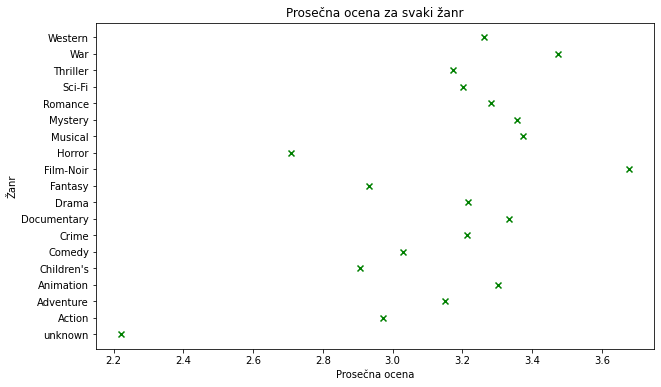

In [32]:
plt.figure(figsize=(10, 6))
plt.scatter(x = average_ratings_for_genres, y = [g for g in genres['genre']], color='green', marker='x')
plt.ylabel('Žanr')
plt.xlabel('Prosečna ocena')
plt.title('Prosečna ocena za svaki žanr')
plt.show()

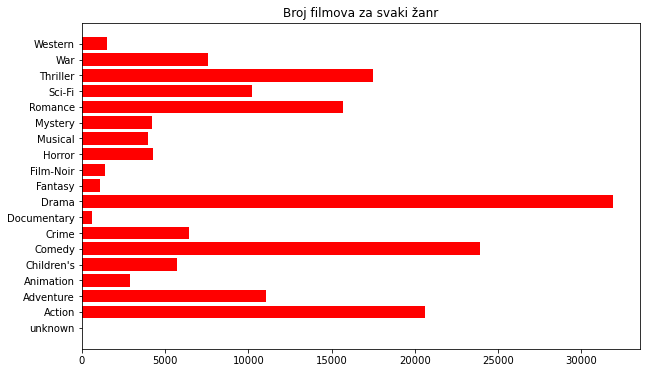

In [33]:
plt.figure(figsize=(10, 6))
plt.barh([g for g in genres['genre']], list(number_of_ratings_for_genre.values()), color='red')
plt.title('Broj filmova za svaki žanr')
plt.show()

### Rad sa podacima

Formiramo USER-ITEM matricu nad trening podacima (na drugačiji način nego nad svim podacima, zbog toga što u trening podacima se ne nalaze svi filmovi, a nama je potrebno da ih imamo u toj matrici pa ih dodajemo ovde sa svim vrednostima 0 u matrici).

In [34]:
ui_matrix_train = np.zeros((number_of_users, number_of_items))
for row in train_data.itertuples():
    ui_matrix_train[row[1]-1, row[2]-2] = row[3]
    
ui_matrix_train.shape

(943, 1682)

In [35]:
ui_matrix_train

array([[0., 4., 3., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 5.],
       [0., 0., 0., ..., 0., 0., 0.],
       [5., 0., 0., ..., 0., 0., 0.]])

Ukupno svih filmova imamo 1682, a u trening skupu ih imamo 1650.

In [36]:
number_of_items

1682

In [37]:
train_data['item'].unique().shape[0]

1648

Broj različitih korisnika u trening skupu.

In [38]:
train_data['user'].unique().shape[0]

943

Broj različitih korisnika u test skupu.

In [39]:
test_data['user'].unique().shape[0]

653

Računamo vrednost kovarijanse između dva korisnika na osnovu sledeće formule:

\begin{align}
 cov(u_{i}, u_{j}) = \frac{1}{|I|}\sum_{k \in (I_{i} \cap I_{j})} r_{ik} \bullet r_{jk} - \frac{1}{|I|^2} \sum_{k \in I} r_{ik} \bullet \sum_{k \in I} r_{jk}
\end{align}

In [40]:
def calculate_covariance_between_users(ui_matrix, i, j):
    if (i != j):
        ratings_i = ui_matrix[i,:]
        ratings_j = ui_matrix[j,:]
    
        common_items = (ratings_i != 0) & (ratings_j != 0)
    
        part1 = np.sum(ratings_i[common_items]*ratings_j[common_items])*(1/number_of_items)
        part2 = np.sum(ratings_i)*np.sum(ratings_j)*(1/(number_of_items**2))
    
        return part1 - part2
    else:
        return float('inf')

In [41]:
calculate_covariance_between_users(ui_matrix_train, 1, 2)

0.0176726081995699

In [42]:
calculate_covariance_between_users(ui_matrix_train, 2, 1)

0.0176726081995699

In [43]:
calculate_covariance_between_users(ui_matrix_train, 100, 99)

-0.00226783979776072

Formiramo matricu kovarijanse za svaka dva korisnika koristeći prethodno definisanu funkciju koja računa kovarijansu između dva korisnika. S obzirom na to da je matrica simetrična, dovoljno je računati samo pola matrice.

In [44]:
covariance_matrix = np.zeros((number_of_users, number_of_users))
for i in range(number_of_users):
    for j in range(i, number_of_users):
        covariance_matrix[i, j] = calculate_covariance_between_users(ui_matrix_train, i, j)
        covariance_matrix[j, i] = covariance_matrix[i, j]

In [45]:
covariance_matrix

array([[        inf,  0.04729167, -0.02086017, ...,  0.03691602,
         0.11552763,  0.41747481],
       [ 0.04729167,         inf,  0.01767261, ...,  0.0230354 ,
         0.07238071,  0.03677534],
       [-0.02086017,  0.01767261,         inf, ...,  0.00636664,
         0.03921779, -0.01311926],
       ...,
       [ 0.03691602,  0.0230354 ,  0.00636664, ...,         inf,
         0.03458279,  0.03369842],
       [ 0.11552763,  0.07238071,  0.03921779, ...,  0.03458279,
                inf,  0.12853484],
       [ 0.41747481,  0.03677534, -0.01311926, ...,  0.03369842,
         0.12853484,         inf]])

In [46]:
covariance_matrix[10, 20]

0.027783158320384672

In [47]:
covariance_matrix[20, 10]

0.027783158320384672

In [48]:
covariance_matrix[942, 0]

0.4174748084566106

In [49]:
covariance_matrix[0, 942]

0.4174748084566106

Definišemo funkciju koja vraća K najličnijih korisnika korisniku koji se prosleđuje kao argument.

In [50]:
def GetKSimilarUser(user_i, K):
    user_values = covariance_matrix[user_i,:]
    values = user_values.argsort()[-K-1:]
    
    return values[0:K]

In [51]:
print(GetKSimilarUser(0, 10))
for i in GetKSimilarUser(0,10):
    print(covariance_matrix[0, i])

[885 803 275  58 681 822 888 757 915 863]
0.6379366899436008
0.6414706460374306
0.6510269609957003
0.6519148683479408
0.6679389097119814
0.6795997630361906
0.7031080998924047
0.7261109799358387
0.7988013250744754
0.8654841569333829


Definišemo funkciju koja vraća K najrazličitijih korisnika korisniku koji se prosleđuje kao argument.

In [52]:
def GetKDSimilarUser(user_i, K):
    user_values = covariance_matrix[user_i,:]
    
    return user_values.argsort()[:K]

Formiramo niz koji za svakog korisnika iz trening skupa sadrži prosek ocena koje je dao filmovima koje je gledao.

In [53]:
train_users = train_data['user'].unique()
average_ratings = np.zeros(number_of_users)

for user in train_users:
    average_ratings[user-1] = ui_matrix_train[user-1, ui_matrix_train[user-1, :] != 0].mean()
    
average_ratings
    

array([3.63302752, 3.80487805, 2.63157895, 4.38888889, 2.84732824,
       3.64516129, 4.02903226, 3.73913043, 4.5       , 4.20422535,
       3.41044776, 4.45      , 3.06004141, 4.09876543, 2.76923077,
       4.29906542, 2.95454545, 3.90196078, 3.61538462, 3.25714286,
       2.73282443, 3.50537634, 3.59259259, 4.26086957, 4.06153846,
       2.84615385, 3.26315789, 3.74193548, 3.57142857, 3.72727273,
       4.        , 3.28571429, 3.76470588, 4.0625    , 3.1875    ,
       3.75      , 3.75      , 3.625     , 3.66666667, 2.88461538,
       3.70731707, 3.72222222, 3.73529412, 3.73913043, 3.60526316,
       4.16666667, 3.7       , 3.68085106, 2.71751412, 3.23529412,
       3.44444444, 4.22222222, 3.68421053, 3.89361702, 3.23529412,
       3.65333333, 3.43589744, 3.86440678, 3.85053381, 4.1048951 ,
       2.8125    , 3.31073446, 3.15789474, 3.57241379, 3.96610169,
       3.37037037, 3.76923077, 2.84      , 3.97777778, 3.45544554,
       3.68965517, 3.82857143, 3.66      , 3.59375   , 3.32692

Predloženi algoritam

In [54]:
def CFCM(UI, user_u, alpha, K, N):
    Nus = GetKSimilarUser(user_u-1, K)
    Nud = GetKDSimilarUser(user_u-1, K)
    
    # pronalazimo iteme koje korisnik nije ocenio i nad njima primenjujemo algoritam
    unrated_items = np.where(UI[user_u-1, :] == 0)[0]
    number_of_unrated_items = unrated_items.shape[0]
    # rečnik predvidjenih ocena za sve iteme
    all_predicted_ratings = {}
    # drugo, krace ime za matricu kovarijansi
    COV = covariance_matrix
    
    
    for item_i in unrated_items:
        
        # za racunanje dela iznad razlomacke crte u prvom delu gde se posmatraju slicni
        similar = np.zeros(K)
        # za racunanje dela ispod razlomacke crte u prvom delu gde se posmatraju slicni
        divide_s = np.zeros(K)
        # za racunanje dela iznad razlomacke crte u drugom delu gde se posmatraju razliciti
        disimilar = np.zeros(K)
        # za racunanje dela ispod razlomacke crte u drugom delu gde se posmatraju razliciti
        divide_ds = np.zeros(K)
    
        for i in range(K):
            if alpha != 0:
                similar[i] = COV[user_u-1, Nus[i]]*(UI[Nus[i],item_i] - average_ratings[Nus[i]])
                divide_s[i] = np.abs(COV[user_u-1, Nus[i]])
            if alpha != 1:
                disimilar[i] = np.abs(COV[user_u-1, Nud[i]])*(UI[Nud[i],item_i] - average_ratings[Nud[i]])
                divide_ds[i] = np.abs(COV[user_u-1, Nud[i]])
        
        # formula iz algoritma
        if (alpha != 0 and alpha != 1):
            rui = average_ratings[user_u-1] + alpha * (np.sum(similar)/np.sum(divide_s)) + (1-alpha) * (np.sum(disimilar)/np.sum(divide_ds))
        elif (alpha == 0):
            rui = average_ratings[user_u-1] + (1-alpha) * (np.sum(disimilar)/np.sum(divide_ds))
        elif (alpha == 1):
            rui = average_ratings[user_u-1] + alpha * (np.sum(similar)/np.sum(divide_s))
        
        # za svaki element stavljamo u niz
        all_predicted_ratings[item_i+1] = rui
        #print(rui) 
        
    # uzimamo prvih N najboljih predloga za usera u     
    sorted_ratings = sorted(all_predicted_ratings.items(), key=lambda x: x[1], reverse=True)
    sorted_i = [rating[0] for rating in sorted_ratings[:N]]
    sorted_r = [rating[1] for rating in sorted_ratings[:N]]
    
    # rezultat je lista parova itema i njihovih ocena
    Result = list(zip(sorted_i, sorted_r))
    return Result

In [55]:
CFCM(ui_matrix_train, 200, 0.8, 10, 5)

[(180, 4.523469504241303),
 (194, 4.051320619784957),
 (167, 4.036353115493646),
 (97, 3.964419680871499),
 (422, 3.8668083858506375)]

In [56]:
CFCM(ui_matrix_train, 1, 0.8, 10, 5)

[(172, 3.8285237217298667),
 (180, 3.4844098110462283),
 (317, 3.4079642947974307),
 (473, 3.2728623765735794),
 (567, 3.0366727508615536)]

Definišemo funkciju koja primenjuje naš algoritam za dato alfa, K i N.

In [57]:
def recommendToTestUsers(alpha, K, N):
    users = test_data['user'].unique()
    
    R = {}
    
    for user in users:
        R[user] = CFCM(ui_matrix_train, user, alpha = alpha, K = K, N = N)
        
    return R

Za svakog test korisnika vraćamo filmove koje je gledao i ocene koje im je dao.

In [58]:
def getTestItems():
    test_users = test_data['user'].unique()
    T = {}
    for test_user in test_users:
        T[test_user] = list(zip(np.array(test_data[test_data['user'] == test_user]['item']), np.array(test_data[test_data['user'] == test_user]['rating'])))

    return T

In [59]:
test_data

,user,item,rating,timestamp
0,1,1,5,874965758
1,1,2,3,876893171
2,1,8,1,875072484
3,1,9,5,878543541
4,1,21,1,878542772
...,...,...,...,...
19995,655,693,3,888984506
19996,655,736,3,888685734
19997,655,918,2,892436609
19998,655,1403,3,888813372


Definišemo funkciju za računanje metrike F1.

In [60]:
def getF1(R, T):
    test_users = test_data['user'].unique()
    number_of_test_users = test_data['user'].unique().shape[0]
    
    A = np.zeros(number_of_test_users)
    B = np.zeros(number_of_test_users)
    C = np.zeros(number_of_test_users)
    i = 0
    for test_user in test_users:
        A[i] = len(set([t[0] for t in T[test_user]]) & set([r[0] for r in R[test_user]]))
        B[i] = len(T[test_user])
        C[i] = len(R[test_user])
        i = i + 1
        
    Recall = np.sum(A)/np.sum(B)
    Precision = np.sum(A)/np.sum(C)
    
    return 2 / (1/Precision + 1/Recall)

Definišemo funkcije za računanje metrike MAE. Prilikom primene algoritma će se računati metrika NMAE (u funkciji applyAlgorithm), normalizacijom rezultata funkcije getMAE.

In [61]:
def getRating(X, item):
    for x in X:        
        if (x[0] == item):
            return x[1]
    return inf

In [62]:
def getMAE(R, T):
    S = 0
    Num = 0
    for test_user in T:
        test_items = [x[0] for x in T[test_user]]
        
        recommended_items = [y[0] for y in R[test_user]]
        
        A = set(test_items) & set(recommended_items)
        Num += len(A)
        if (len(A)):
            for item in A:
                S += abs(getRating(T[test_user], item) - getRating(R[test_user], item))

    return S/Num          

Definišemo funkcije za računanje diverziteta.

In [63]:
def findUsersForItem(item):
    x = np.array([u != 0 for u in ui_matrix_train[:, item - 1]])
    return set(np.where(x == True)[0])

In [64]:
def jaccard_similarity(items_of_user):
    S = 0
    
    for i in range(len(items_of_user)):
        for j in range(len(items_of_user)):
            if (i < j):
                users_i = findUsersForItem(items_of_user[i])
                users_j = findUsersForItem(items_of_user[j])
                
                S += len(users_i & users_j)/len(users_i | users_j)
                
    return S

In [65]:
def getDiversity(R):
    number_of_test_users = test_data['user'].unique().shape[0]    
    result = np.zeros(number_of_test_users)
    i = 0

    for r in R:
        items_of_user = [x[0] for x in R[r]]
        result[i] = 1 - (jaccard_similarity(items_of_user))/((1/2) * len(R[r]) * (len(R[r]) - 1))
        i = i + 1
        
    Diversity = np.sum(result) / number_of_test_users
        
    return Diversity

Primenjujemo algoritam za različite vrednosti parametara i pamtimo evaluacije za svaku od tih kombinacija parametara.

In [66]:
def applyAlgorithm(k):
    T = getTestItems()
    alphas = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]

    F1s = []
    MAEs = []
    NMAEs = []
    Ds = []

    print(k)
    for alpha in alphas:
        print(alpha)

        R = recommendToTestUsers(alpha = alpha, K = k, N = 20)

        F1 = getF1(R, T)
        F1s.append(F1)

        MAE = getMAE(R, T)
        MAEs.append(MAE)
        NMAEs.append(MAE * (1/(5-1)))

        diversity = getDiversity(R)
        Ds.append(diversity)

    evaluations = list(zip(alphas, F1s, MAEs, NMAEs, Ds))
    
    return evaluations   

In [67]:
%%time
evaluations = {}
evaluations[5] = applyAlgorithm(5)
print(evaluations[5])

5
0
0.1
0.2
0.3
0.4
0.5
0.6
0.7
0.8
0.9
1
[(0, 0.015789473684210527, 1.4493807214491736, 0.3623451803622934, 0.7923176114418583), (0.1, 0.01645493042952208, 1.4545470657168353, 0.36363676642920884, 0.7864179045593979), (0.2, 0.017362371445856017, 1.47853590997247, 0.3696339774931175, 0.7790538431357243), (0.3, 0.019540229885057474, 1.5830147298723027, 0.3957536824680757, 0.7698914008190412), (0.4, 0.023956442831215976, 1.6571589112783767, 0.41428972781959417, 0.7615902804128296), (0.5, 0.03163944343617665, 1.5435306230978525, 0.3858826557744631, 0.7596723725242841), (0.6, 0.04035087719298246, 1.3525546055566224, 0.3381386513891556, 0.7617192936564154), (0.7, 0.044646098003629765, 1.1682989998307713, 0.29207474995769284, 0.7635739886905998), (0.8, 0.04627949183303085, 0.9820900719746567, 0.24552251799366417, 0.76548891020018), (0.9, 0.04670296430732002, 0.8665168465060495, 0.21662921162651239, 0.7675394928766237), (1, 0.04767090139140955, 0.846931600918683, 0.21173290022967076, 0.769344

In [68]:
%%time
evaluations[15] = applyAlgorithm(15)
print(evaluations[15])

15
0
0.1
0.2
0.3
0.4
0.5
0.6
0.7
0.8
0.9
1
[(0, 0.01427707199032063, 1.8105994112166617, 0.4526498528041654, 0.7635158145719543), (0.1, 0.016091954022988506, 1.9058109882922516, 0.4764527470730629, 0.7565085354998436), (0.2, 0.017846339987900785, 1.9352640791786653, 0.4838160197946663, 0.7480938089496734), (0.3, 0.021415607985480943, 2.0275269147314035, 0.5068817286828509, 0.7379511544908492), (0.4, 0.026436781609195405, 2.0170237332682124, 0.5042559333170531, 0.7289513839903417), (0.5, 0.034845735027223226, 1.857523902195788, 0.464380975548947, 0.7243777456071879), (0.6, 0.04113732607380521, 1.6315288225863342, 0.40788220564658356, 0.7273803270651964), (0.7, 0.04603750756200847, 1.4431401019220595, 0.3607850254805149, 0.7296016320657669), (0.8, 0.04779189352692075, 1.2258238713840697, 0.3064559678460174, 0.7311435020532974), (0.9, 0.04930429522081065, 1.052871782285552, 0.263217945571388, 0.7331733726101921), (1, 0.04972776769509982, 0.9354755708941621, 0.23386889272354053, 0.73502654

In [69]:
%%time
evaluations[25] = applyAlgorithm(25)
print(evaluations[25])

25
0
0.1
0.2
0.3
0.4
0.5
0.6
0.7
0.8
0.9
1
[(0, 0.01482153660012099, 1.9323355650235168, 0.4830838912558792, 0.7543531758530121), (0.1, 0.016999395039322445, 2.038096709121698, 0.5095241772804245, 0.7471486485280465), (0.2, 0.018148820326678767, 2.1067389755083292, 0.5266847438770823, 0.7393013893883137), (0.3, 0.021294615849969754, 2.195230622377213, 0.5488076555943032, 0.7284813440909914), (0.4, 0.028070175438596492, 2.1702329221703285, 0.5425582305425821, 0.719626367040574), (0.5, 0.03502722323049002, 1.990006336527445, 0.49750158413186124, 0.7143370918873789), (0.6, 0.04077434966727163, 1.7515716858348516, 0.4378929214587129, 0.7142240169740086), (0.7, 0.045372050816696916, 1.5562779249753118, 0.38906948124382795, 0.7177315876275306), (0.8, 0.04888082274652148, 1.366396785502915, 0.3415991963757288, 0.7203866556421259), (0.9, 0.0499697519661222, 1.1748505178239756, 0.2937126294559939, 0.7223538992555073), (1, 0.05057471264367816, 1.0255772887922932, 0.2563943221980733, 0.7243803308

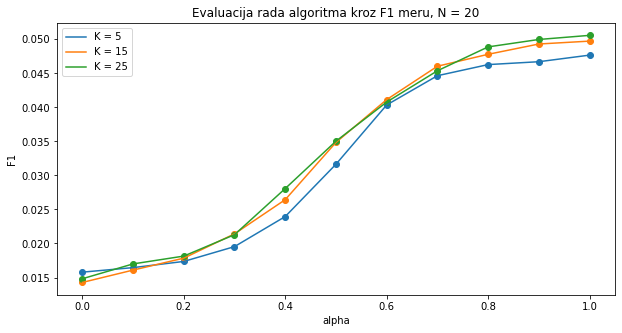

In [70]:
plt.figure(figsize = (10, 5))
plt.title('Evaluacija rada algoritma kroz F1 meru, N = 20')
plt.plot([element[0] for element in evaluations[5]], [element[1] for element in evaluations[5]], label = 'K = 5')
plt.scatter([element[0] for element in evaluations[5]], [element[1] for element in evaluations[5]])
plt.plot([element[0] for element in evaluations[15]], [element[1] for element in evaluations[15]], label = 'K = 15')
plt.scatter([element[0] for element in evaluations[15]], [element[1] for element in evaluations[15]])
plt.plot([element[0] for element in evaluations[25]], [element[1] for element in evaluations[25]], label = 'K = 25')
plt.scatter([element[0] for element in evaluations[25]], [element[1] for element in evaluations[25]])
plt.legend(loc = 'best')
plt.xlabel('alpha')
plt.ylabel('F1')
plt.show()

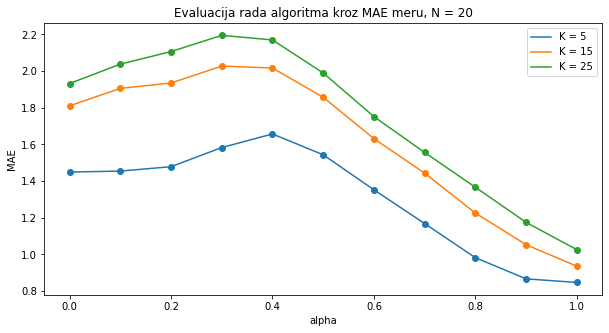

In [71]:
plt.figure(figsize = (10, 5))
plt.title('Evaluacija rada algoritma kroz MAE meru, N = 20')
plt.plot([element[0] for element in evaluations[5]], [element[2] for element in evaluations[5]], label = 'K = 5')
plt.scatter([element[0] for element in evaluations[5]], [element[2] for element in evaluations[5]])
plt.plot([element[0] for element in evaluations[15]], [element[2] for element in evaluations[15]], label = 'K = 15')
plt.scatter([element[0] for element in evaluations[15]], [element[2] for element in evaluations[15]])
plt.plot([element[0] for element in evaluations[25]], [element[2] for element in evaluations[25]], label = 'K = 25')
plt.scatter([element[0] for element in evaluations[25]], [element[2] for element in evaluations[25]])
plt.legend(loc = 'best')
plt.xlabel('alpha')
plt.ylabel('MAE')
plt.show()

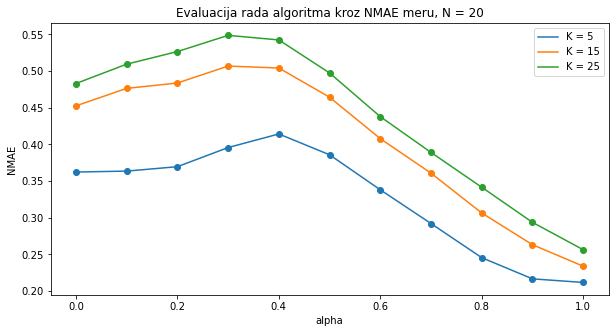

In [72]:
plt.figure(figsize = (10, 5))
plt.title('Evaluacija rada algoritma kroz NMAE meru, N = 20')
plt.plot([element[0] for element in evaluations[5]], [element[3] for element in evaluations[5]], label = 'K = 5')
plt.scatter([element[0] for element in evaluations[5]], [element[3] for element in evaluations[5]])
plt.plot([element[0] for element in evaluations[15]], [element[3] for element in evaluations[15]], label = 'K = 15')
plt.scatter([element[0] for element in evaluations[15]], [element[3] for element in evaluations[15]])
plt.plot([element[0] for element in evaluations[25]], [element[3] for element in evaluations[25]], label = 'K = 25')
plt.scatter([element[0] for element in evaluations[25]], [element[3] for element in evaluations[25]])
plt.legend(loc = 'best')
plt.xlabel('alpha')
plt.ylabel('NMAE')
plt.show()

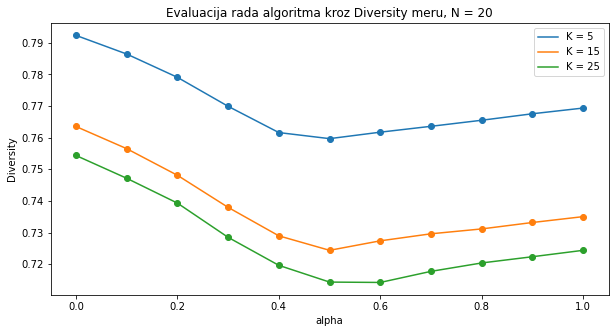

In [73]:
plt.figure(figsize = (10, 5))
plt.title('Evaluacija rada algoritma kroz Diversity meru, N = 20')
plt.plot([element[0] for element in evaluations[5]], [element[4] for element in evaluations[5]], label = 'K = 5')
plt.scatter([element[0] for element in evaluations[5]], [element[4] for element in evaluations[5]])
plt.plot([element[0] for element in evaluations[15]], [element[4] for element in evaluations[15]], label = 'K = 15')
plt.scatter([element[0] for element in evaluations[15]], [element[4] for element in evaluations[15]])
plt.plot([element[0] for element in evaluations[25]], [element[4] for element in evaluations[25]], label = 'K = 25')
plt.scatter([element[0] for element in evaluations[25]], [element[4] for element in evaluations[25]])
plt.legend(loc = 'best')
plt.xlabel('alpha')
plt.ylabel('Diversity')
plt.show()

Nakon izvršavanja algoritma nad ovim test i trening podacima, primećujemo da smo dobili veoma slične rezultate kao i za prvu podelu, samo u drugim opsezima.